In [3]:
import numpy as np
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

# Lecture 3: Knowledge Modeling and Likelihood Tests
## Pattern Recognition, Fall 2022

**Ivan Dokmanić**


<img src="figs/sada-unibas-0.svg" width="60%" float="left">


# Updates

- Results of the questionnaire



# Last session's quiz

- How would $k$-means perform on catness and dogness? Could it be fooled as well?
    - (Depends on pixel coding!)
- Recall our set of threshold-based clasifiers:

$$
  \mathcal{A} = \text{the set of algorithms} = \left\{ f(x) = \begin{cases} 0 & \text{if}~ x \leq \eta \\ 1 & \text{if}~ x > \eta \end{cases} \ \bigg| \ \eta \in \mathbb{R} \right \}
$$
- Write down in a similar form the set of all perceptrons that work on 100-dimensional vectors

# The plan for today?

We are (still ;-)) setting up the framework!

- Recall the Clever Hans!
- Recap of snail sex prediction: what is the "optimal" prediction? 
    - (when optimal = the one that makes the fewest mistakes)
- Prediction via optimization
- The power of likelihood ratios
- Illustrations with two Gaussians + beyond counting mistakes

# Patterns, predictions, and actions

We keep following Chapter 2 from Hardt and Recht's book, but adding lots of illustrations and code

# Predicting Snail Sex from Number of Rings

A gorgeous example of an abalone snail

<img src="https://static01.nyt.com/images/2022/03/08/science/24sci-abalone/24sci-abalone-videoSixteenByNine3000.jpg" width="70%"/>

<font size="3">Picture from New York Times</font>

<IPython.core.display.Javascript object>


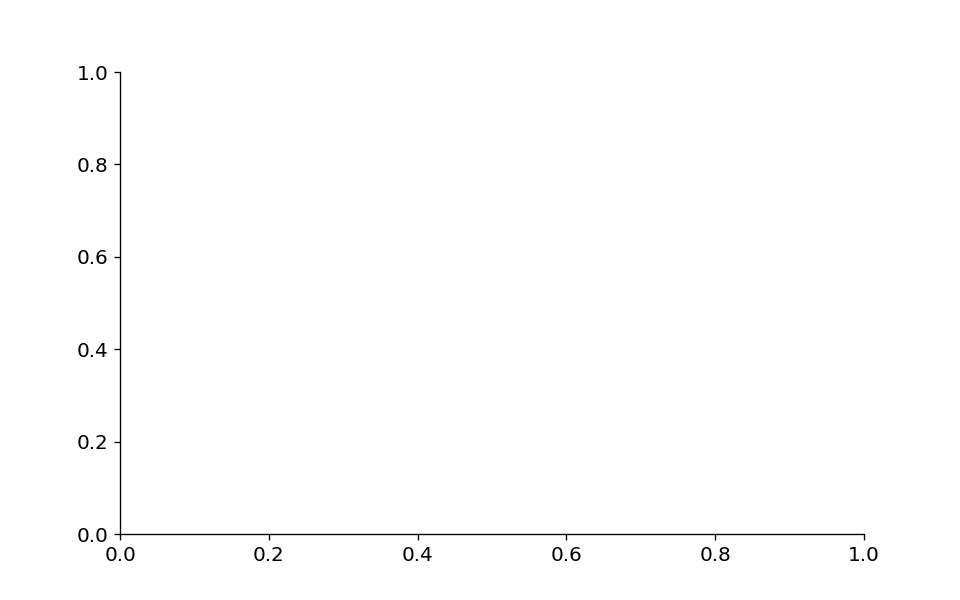

NameError: name 'males' is not defined

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.bar(np.arange(30) - 0.2, males, width=0.4)
ax.bar(np.arange(30) + 0.2, females, width=0.4)

ax.legend(['Male', 'Female'], frameon=False)
ax.set_xlabel('Number of rings')
ax.set_ylabel('Number of snails');

# What is the "best" classifier?

- We have a binary prediction problem
- We _define_ "best predictor" as the one that makes the fewest mistakes
    - This is called _the minimum error rule_
- There are two kinds of mistakes:
    - Predicting a male when the true snail is female
    - Predicting a female when the true snail is male

<IPython.core.display.Javascript object>


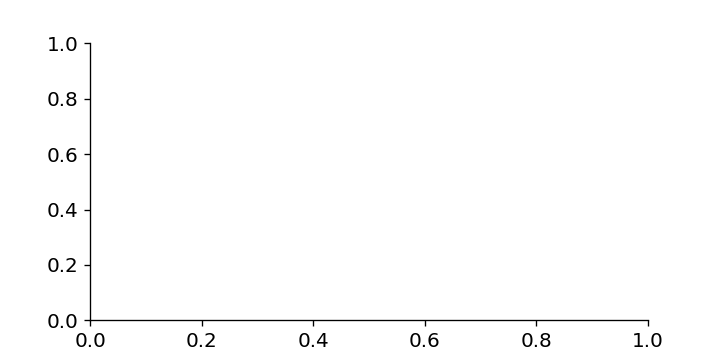

NameError: name 'males' is not defined

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(-np.array([-1, 1])[np.int8(males > females)[3:]]);

# A good but impractical rule

- a good rule with compelling intuition
- alas, to apply it, we need to measure the entire population of snails
- impractical and largely defeats the purpose
- if we only measure a subset, then what do we believe when we apply the thing in the real world?
- we need (domain or otherwise) knowledge about the problem / population
    - this makes prediction possible


# Modeling knowledge

- Knowledge about the population is what makes prediction without enumeration possible
- There are different ways to represent "knowledge" (or model populations)
- In machine learning we model populations by probability distributions
    - We assume that both the training data and the data we will apply our algorithms to are independent samples from a joint distribution of objects and labels


- You could simply flip to the next slide but I'd like you to contemplate the meaning of this. This is really a semi-religious assumption which seems to be extremely useful in practice

<IPython.core.display.Javascript object>


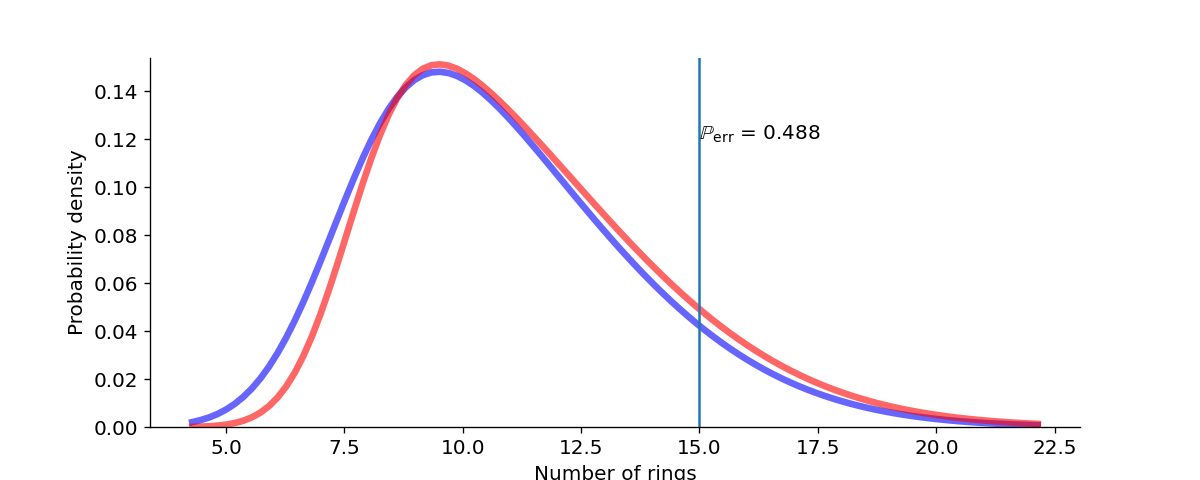

interactive(children=(FloatSlider(value=15.0, description='thr', max=22.5, min=5.0), Output()), _dom_classes=(…

In [6]:
from scipy.stats import skewnorm

# btw, do I need to explain what a probability distribution / density function is?

l1, s1, a1 = 7.40, 4.48, 3.12
l2, s2, a2 = 7.63, 4.67, 4.34

x = np.linspace(skewnorm.ppf(0.001, a1, loc=l1, scale=s1),
                skewnorm.ppf(0.999, a1, loc=l1, scale=s1), 
                100)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
line1, = ax.plot(x, skewnorm.pdf(x, a1, loc=l1, scale=s1),
       'b-', lw=4, alpha=0.6, label='skewnorm pdf')
line2, = ax.plot(x, skewnorm.pdf(x, a2, loc=l2, scale=s2),
       'r-', lw=4, alpha=0.6, label='skewnorm pdf')
text = ax.text(15, 0.12, '0.000')

ax.set_xlabel('Number of rings')
ax.set_ylabel('Probability density')
ax.set_ylim(0, 0.154)

thr0 = 15
thrline, = ax.plot([thr0, thr0], [0, 0.20])

def update(thr=thr0):
    err1 = skewnorm.cdf(thr, a2, loc=l2, scale=s2)
    err2 = 1 - skewnorm.cdf(thr, a1, loc=l1, scale=s1)
    
    p_error = (err1 + err2) / 2
    
    thrline.set_xdata([thr, thr])
    text.set_text('$\mathbb{P}_{\mathrm{err}}$ = %0.3f' % (p_error,))
    fig.canvas.draw_idle()
    
interact(update, thr=(5.0, 22.5, 0.1));

# The Dogma

- We assume that there is some joint probability distribution over patterns and labels, $p_{X, Y}(x, y)$
- (When all is clear we write simply $p(x, y)$ for simplicity)

- In a week or two we will talk about supervised learning where the training set $\{ (x_i, y_i) \}_{i = 1}^n$ consists of independent samples from $p(x, y)$, but the true $p$ is unknown 
- Here we assume that $p$ is known—even so there are many important questions to answer
- notation: $p$ vs $\mathbb{P}$


# Prediction from statistical models

- Let's further formalize the minimum error rule for binary classification
- PPA: It is convenient both mathematically and conceptually to specify the joint distribution via class-conditional probabilities

- We assume that $Y$ has _a priori_ probabilities

$$
    p_0 = \mathbb{P}[Y = 0] \quad \quad p_1 = \mathbb{P}[Y = 1]
$$

- $p_0$ and $p_1$ are proportions of the two classes in the population
    - if we draw a large number $n$ of samples from $p$ there will be approximatialy $p_0 n$ labels $0$ and $p_1 n$ labels $1$
- In the snail example we had $p_0 = p_1 = \frac{1}{2}$ ("balanced" classes)


# Prediction from statistical models (cont'd)

- The patterns are modeled by a random vector $X$ (jointly distributed with labels $Y$)
- The meaning of "jointly": the distribution of $X$ depends on whether $Y$ is 0 or 1
- $\Rightarrow$ there are two different statistical models for the data, one for $Y = 1$ and another for $Y = -1$
- These statistical models are the conditional probabilities


$$
    p(x | Y = 0) \quad \quad \text{and} \quad \quad p(x | Y = 1)
$$

- Generalization to different kinds of labels is straightforward
- $p(x | Y = y)$ called _generative models_ or _likelihood functions_
- the joint probability is then

$$
    p(x, y) = p(x | Y = y) p(Y = y)
$$

# Prediction via optimization

We want to compute _optimal_ predictions and the way to do it is by _optimization_.

- a predictor is a rule, a formula, or most generally, an algorithm
- $\Rightarrow$ the quest for an optimal predictor involves optimization over algorithms
- algorithms (or functions) are maps from the set of patterns, $\mathcal{X}$, to the set of labels, $\mathcal{Y}$

What we did earlier is

$$
  \mathcal{A} = \text{the set of algorithms} = \left\{ f(x) = \begin{cases} 0 & \text{if}~ x \leq \eta \\ 1 & \text{if}~ x > \eta \end{cases} \ \bigg| \ \eta \in \mathbb{R} \right \}
$$


and the optimization problem was

$$
\begin{aligned}
      \text{find}~f~\in~\mathcal{A} ~\text{which minimizes} ~
      \mathbb{P}(\text{mistake})
\end{aligned}
$$
where

$$
\begin{aligned}
    \mathbb{P}(\text{mistake})
      &=
      \mathbb{P}(\underbrace{f(X) = 0 \, |\, Y = 1}_{\text{we say 0, truth is 1}}) \cdot \mathbb{P}(Y = 1)
      \quad + \quad
      \mathbb{P}(\underbrace{f(X) = 1 \, |\, Y = 0}_{\text{we say 1, truth is 0}}) \cdot \mathbb{P}(Y = 0) \\
      &=
      \mathbb{P}(X \leq \eta \, |\, Y = 1) \mathbb{P}(Y = 1)
      +
      \mathbb{P}(X > \eta \, |\, Y = 1) \mathbb{P}(Y = 0) \\
\end{aligned}
$$
- we are using the law of total probability
- intuitively, if class 0 (or 1) is very rare it does not contribute much to the probability of mistake
- this already points to possible issues!

# Our prediction is random

- We obtain our prediction by applying an function / algorithm $f$ to $X$
- $X$ is a random variable (vector)—this is just how we model knowledge!
- Recall that $X$ is modeled as a random draw from $p(x) = \int p(x, y) dy$
- The common notation for an estimate of some quantity is with a hat. We will thus write

$$
\hat{Y} \equiv \hat{Y}(X) \equiv f(X)
$$

- most commonly we will simply write $\hat{Y}$
- it is understood that $\hat{Y}$ is an _estimate_ or a _prediction_ calculated from the observed pattern $X$
- we will often look at binary classification where $\mathcal{Y} = \{0, 1\}$ or $\mathcal{Y} = \{-1, 1\}$


# Risk

- How well is our pattern recognizer doing on "unseen" or "general" patterns from $\mathbb{P}$?
- _**Loss**_ is the price we (choose to) pay for different kinds of mistakes. We've seen:
$$
\mathrm{loss}(\hat{y}, y) = \begin{cases} 0 & \hat{y} = y \\ 1 & \hat{y} \neq y \end{cases}.
$$

**Definition (Risk).** We define the risk associated with $\hat{Y}$ (that is to say, with the chosen rule / algorithm $f \in \mathcal{A}$), as

$$
    R[\hat{Y}] := \mathbb{E}_{(X, Y) \sim \mathbb{P}}[\mathrm{loss}(\hat{Y}(X), Y)].
$$

NB: explain this by first averaging over samples from $\mathbb{P}$ (like, this is our test set), but then ask: how many samples should we take to get a reliable sense of performance?

# Risk-minimizing prediction

It is reasonable to choose that pattern prediction rule which minimizes risk. We write

$$
    \hat{Y} = f_{\text{best}}(X)
    ~\text{where}~
    f_{\text{best}} = \arg\min_{f \in \mathcal{A}} R[f(X)].
$$

- an infinite-dimensional _optimization_ problem: for each value of $x$ we need to assign a different optimal value
- luckily: not a biggie

# The optimal predictor

$$
\widehat{Y}(x)=\mathbb{1}\bigg\{\mathbb{P}[Y=1 \mid X=x] \geq \text{factor} \cdot \mathbb{P}[Y=0 \mid X=x]\bigg\}
$$
where
$$
\text{factor} = \frac{\operatorname{loss}(1,0)-\operatorname{loss}(0,0)}{\operatorname{loss}(0,1)-\operatorname{loss}(1,1)}
$$
Easy proof by the law of iterated expectation:

$$
    \mathbb{E}[\operatorname{loss}(\widehat{Y}(X), Y)]=\mathbb{E}[\mathbb{E}[\operatorname{loss}(\widehat{Y}(X), Y) \mid X]]
$$

- outer expectation is over draws of $X$, inner over draws of $Y$ conditional on $X$ (samples from $\mathbb{P}(Y|X)$)
- no constraints on $\widehat{Y}$ so we can minimize the expression for each $X = x$ independently

We compute expected losses for each prediction (0 or 1):

- $\mathbb{E}[\operatorname{loss}(0, Y) \mid X = x] = \operatorname{loss}(0, 0) \mathbb{P}[Y = 0 \mid X = x] + \operatorname{loss}(0, 1) \mathbb{P}[Y = 1 \mid X = x]$ 

- $\mathbb{E}[\operatorname{loss}(1, Y) \mid X = x] = \operatorname{loss}(1, 0) \mathbb{P}[Y = 0 \mid X = x] + \operatorname{loss}(1, 1) \mathbb{P}[Y = 1 \mid X = x]$

The optimal assignment is to output $\widehat{Y}(x) = 1$ whenever 

$$
\mathbb{E}[\operatorname{loss}(1, Y) \mid X = x]
\leq
\mathbb{E}[\operatorname{loss}(0, Y) \mid X = x]
$$ 

The desired result follows by rearranging.



# A bit technical: likelihood ratios


Recall that
- Probabilities like $\mathbb{P}[Y = y \mid X = x]$ are called _posterior probabilities_
- Probabilities like $p(x \mid Y = y)$ are called _likelihoods_
    - $p(x)$ is the _density_ of the marginal distribution of $X$

They are related by the Bayes rule:
$$
\mathbb{P}[Y=y \mid X=x]=\frac{p(x \mid Y=y) p_y}{p(x)}
$$

Using likelihoods our optimal rule becomes

$$
\widehat{Y}(x) = \mathbb{1}\left\{\frac{p(x \mid Y=1)}{p(x \mid Y=0)} \geq \frac{p_0(\operatorname{loss}(1,0)-\operatorname{loss}(0,0))}{p_1(\operatorname{loss}(0,1)-\operatorname{loss}(1,1))}\right\}
$$

$\Rightarrow$ an example of a _likelihood ratio test_

# Likelihood ratios

$$
    \mathcal{L}(x):=\frac{p(x \mid Y=1)}{p(x \mid Y=0)}
$$

A _likelihood ratio test_ is a predictor of the form

$$
    \widehat{Y}(x)=\mathbb{1}\{\mathcal{L}(x) \geq \eta\}
$$

for some threshold $\eta > 0$.

Note: this shows that we do not need to know the likelihoods exactly to compute the optimal binary predictor. Any function $t(x)$ such that $t(x) \leq \eta \Leftrightarrow \mathcal{L}(x) \leq \eta$ will do. In particular, monotonic functions of $\mathcal{L}$ work. A popular choice is the logarithm,

$$ 
    \widehat{Y}_{\log }(x)=\mathbb{1}\{\log p(x \mid Y=1)-\log p(x \mid Y=0) \geq \log (\eta)\}.
$$

# Example: signal and noise, or needle in a haystack

- Suppose that 
    - when $Y = 0$ we observe $\omega$, where $\omega \sim \mathcal{N}(0, 1)$
    - when $Y = 1$ we observe $\omega + s$ for a deterministic scalar $s$
- Then
$$
\begin{align}
    p(x \,|\, Y = 0) &= \mathcal{N}(0, 1) = \tfrac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \\
    p(x \,|\, Y = 1) &= \mathcal{N}(s, 1) = \tfrac{1}{\sqrt{2\pi}} e^{-\frac{(x - s)^2}{2}}
\end{align}
$$
- The shift $s$ determines how hard it is to predict $Y$

<IPython.core.display.Javascript object>


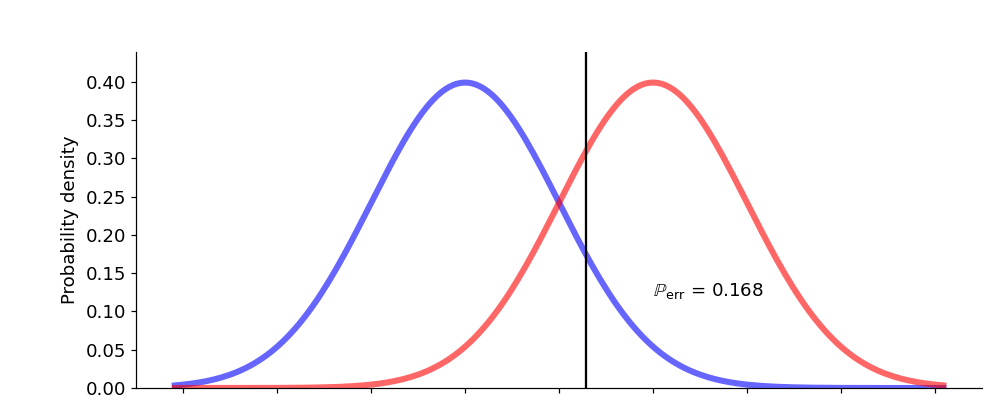

interactive(children=(FloatSlider(value=0.0, description='thr', max=5.090232306167813, min=-3.090232306167813,…

In [7]:
from scipy.stats import norm

sigma = 1
loc1 = 0.0
loc2 = 2

x_min = norm.ppf(0.001, loc=min(loc1, loc2), scale=sigma)
x_max = norm.ppf(0.999, loc=max(loc1, loc2), scale=sigma)
x = np.linspace(x_min, x_max, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
line1, = ax.plot(x, norm.pdf(x, loc=loc1, scale=sigma),
       'b-', lw=4, alpha=0.6, label='skewnorm pdf')
line2, = ax.plot(x, norm.pdf(x, loc=loc2, scale=sigma),
       'r-', lw=4, alpha=0.6, label='skewnorm pdf')
text = ax.text(2, 0.12, '$\mathbb{P}_{\mathrm{err}}$ = %0.3f' % (0,))

ax.set_xlabel('Number of rings')
ax.set_ylabel('Probability density')
y_max = 1.1 / sigma / np.sqrt(2 * np.pi)
ax.set_ylim(0, y_max)

thr0 = 0
thrline, = ax.plot([thr0, thr0], [0, y_max], 'k')

def update(thr=thr0):
    err2 = 1 - norm.cdf(thr, loc=loc1, scale=sigma)
    err1 = norm.cdf(thr, loc=loc2, scale=sigma)
    
    p_error = (err1 + err2) / 2
    
    thrline.set_xdata([thr, thr])
    text.set_text('$\mathbb{P}_{\mathrm{err}}$ = %0.3f' % (p_error,))
    fig.canvas.draw_idle()
    
interact(update, thr=(x_min, x_max, (x_max - x_min) / 200));

# The Gaussian example

Shall we calculate a bit? Assume that
- the prior probability $p_1 = \mathbb{P}(Y = 1)$ is very small, $p_1 = 10^{-6}$ (e.g.,  image contains a tumor)
- we pay no cost if we declare $\widehat{Y} = 0$
- if we declare $\widehat{Y} = 1$
    - we incur a cost of 100 if wrong ($Y = 0$) (e.g., additional tests)
    - we gain a _reward_ of 1,000,000 if correct ($Y = 1$) (e.g., healing)

| loss | $\hat{Y}$ = 0 | $\hat{Y}$ = 1|
|-----|--------:|--------:|
| $Y$ = 0 | 0   |  100  |
| $Y$ = 1 | 0 | —1,000,000  |

The optimal threshold is
$$
\log \eta = \log\left( \frac{p_0(\operatorname{loss}(1,0)-\operatorname{loss}(0,0))}{p_1(\operatorname{loss}(0,1)-\operatorname{loss}(1,1))} \right) \approx 4.61
$$


We have

$$
\log p(x \mid Y=1)-\log p(x \mid Y=0)=-\frac{1}{2}(x-s)^2+\frac{1}{2} x^2=s x-\frac{1}{2} s^2
$$

so that the optimal predictor is

$$
\widehat{Y}=\mathbb{1}\left\{s X > \frac{1}{2} s^2+\log (\eta)\right\}
$$

- the optimal rule is _linear_ (as a function of $x$!)

# Types of errors (and successes)

**<center>Confusion table</center>**

|                   | $Y = 0$        | $Y = 1$        |
|-------------------|----------------|----------------|
| $\widehat{Y} = 0$ | true negative  | false negative |
| $\widehat{Y} = 1$ | false positive | true positive  |

1. **True positive rate**: $\mathrm{TPR} = \mathbb{P}[\hat{Y}(X) = 1 \mid Y=1]$. A.k.a. _power_, _sensitivity_, _probability of detection_, _recall_
2. **False negative rate**: $\mathrm{FNR} = 1 - \mathrm{TPR}$: A.k.a. _type-II error_, _probability of missed detection_
3. **False positive rate**: $\mathrm{FPR} = \mathbb{P}[Y(X) = 1 \mid Y=0]$: A.k.a. _size_ or _type I error_ or _probability of false alarm_
4. **True negative rate**: $\mathrm{TNR} = 1 - \mathrm{FPR}$: A.k.a. _specificity_

In [10]:
# let's do a bit more Gaussian stuff before moving on to ROC (stop here and make a video for the rest)

sig1 = 1
sig2 = 3
loc1 = 0.0
loc2 = 4
p1 = 0.3
p2 = 1 - p1

<IPython.core.display.Javascript object>


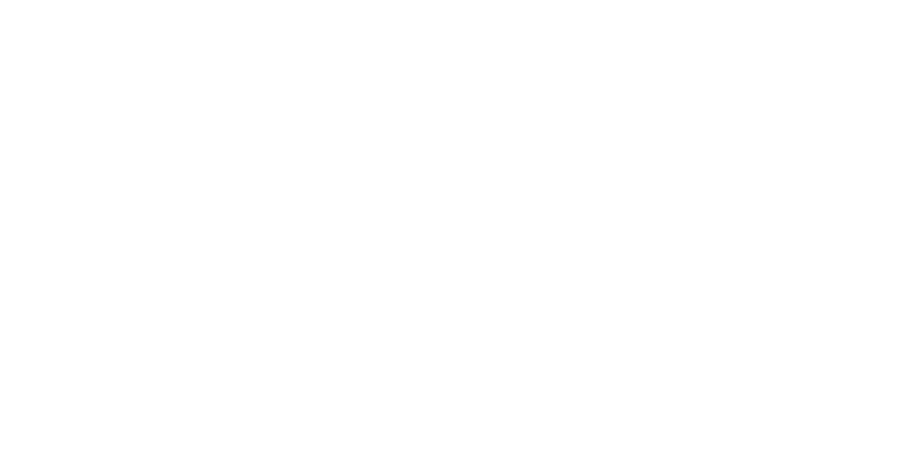

interactive(children=(FloatSlider(value=0.0, description='thr', max=13.27069691850344, min=-9.27069691850344, …

In [11]:
x_min = norm.ppf(0.001, loc=min(loc1, loc2), scale=max(sig1, sig2))
x_max = norm.ppf(0.999, loc=max(loc1, loc2), scale=max(sig1, sig2))                
x = np.linspace(x_min, x_max, 200)

fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))
line1, = ax.plot(x, norm.pdf(x, loc=loc1, scale=sig1),
       'b-', lw=4, alpha=0.6)
line2, = ax.plot(x, norm.pdf(x, loc=loc2, scale=sig2),
       'r-', lw=4, alpha=0.6)
line3, = ax.plot(x, p1*norm.pdf(x, loc=loc1, scale=sig1) + p2*norm.pdf(x, loc=loc2, scale=sig2),
       'k-', lw=1, alpha=0.6)

text_str = '$\mathbb{P}_{\mathrm{err}}$ = %0.3f\n' \
         + 'TPR = %0.3f\n' \
         + 'FNR = %0.3f\n' \
         + 'FPR = %0.3f\n' \
         + 'TNR = %0.3f\n'

text = ax.text(2, 0.25, text_str % (0,0,0,0,0))

ax.set_xlabel('Number of rings')
ax.set_ylabel('Probability density')
ax.legend(['Class 0', 'Class 1'], frameon=False)
y_max = 1.1 / min(sig1, sig2) / np.sqrt(2 * np.pi)
ax.set_ylim(0, y_max)

thr0 = 0
thrline, = ax.plot([thr0, thr0], [0, y_max], 'k')

def update(thr=thr0):

    # FPR = P(\hat{Y} = 1 | Y = 0)
    #     = P(BLUE > thr)
    FPR = 1 - norm.cdf(thr, loc=loc1, scale=sig1)
    # FPR = P(\hat{Y} = 0 | Y = 1)
    #     = P(RED <= thr)
    FNR = norm.cdf(thr, loc=loc2, scale=sig2)
    
    # P(mistake) = P(\hat{Y} = 1 | Y = 0) * p_0 + P(\hat{Y} = 0 | Y = 1) * p_1
    #            = p_0 * FPR + p_1 * FNR
    p_mistake = p1*FPR + p2*FNR
    
    thrline.set_xdata([thr, thr])
    text.set_text(text_str % (p_mistake, 1 - FNR, FNR, FPR, 1 - FPR))
    fig.canvas.draw_idle()

interact(update, thr=(x_min, x_max, (x_max - x_min) / 300));

# amazing stuff: it is now clear that even when TPR is close to 1, we could 
# still be misclassifying half of the positive class

# also: small error classification is not necessarily the holy grail

# Quiz

For this one you may need a pencil, a piece paper, and a bit of thinking...

We derived the optimal classifier when likelihoods are Gaussians whose means differ by $s$,
$$
\widehat{Y}=\mathbb{1}\left\{s X > \frac{1}{2} s^2+\log (\eta)\right\}.
$$
This rule splits the real line in two half-infinite intervals $\left(-\infty, \frac{1}{2}s + \frac{1}{s} \log \eta\right)$ and 
$\left(\frac{1}{2}s + \frac{1}{s} \log \eta, \infty\right)$. Now consider the general case of binary classification with Gaussian likelihoods,
$$
\begin{align}
    p(x \,|\, Y = 0) &= \mathcal{N}(\mu_0, \sigma_0^2) = \tfrac{1}{\sigma_0\sqrt{2\pi}} e^{-\frac{(x - \mu_0)^2}{2\sigma_0^2}} \\
    p(x \,|\, Y = 1) &= \mathcal{N}(\mu_1, \sigma_1^2) = \tfrac{1}{\sigma_1\sqrt{2\pi}} e^{-\frac{(x - \mu_1)^2}{2\sigma_1^2}}
\end{align}
$$
Does it hold for any choice of $\mu_0, \sigma_0, \mu_1, \sigma_1$ that the optimal rule splits the real line in two intervals?

